In [ ]:
import os
os.chdir('..')
print(os.getcwd())
from Code.dataloaders import LFWContrastiveDataset

In [12]:
import torchsummary

In [2]:
l = LFWContrastiveDataset(resize_to=(105,105))

In [3]:
#l.__len__()

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

outdict = l.__getitem__(4)


In [5]:
[outdict[k].shape for k in outdict.keys()]

[torch.Size([3, 3, 105, 105]),
 torch.Size([3, 3, 105, 105]),
 torch.Size([3, 1])]

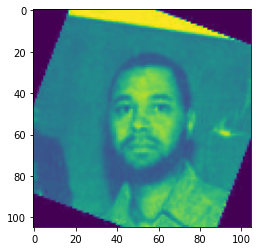

In [6]:
idx = 0
plt.imshow(outdict["x1"][idx,0,...])

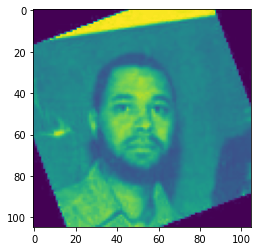

In [7]:
plt.imshow(outdict["x2"][idx,0,...])

In [8]:
outdict["label"][idx]

tensor([1.])

In [21]:
from torch import nn

class ContrastiveModel(nn.Module):
    '''
    A model to produce embedding vectors given an input batched tensor of images
    
    * Note: Input images must be batched tensors of shape (B, in_channels, 105, 105)
    
    Args:
      in_channels (int) : The number of channels in the input image (default=3)
      emb_size (int): The length of the produced embeddings (default=4096)
    '''
    
    def __init__(self, in_channels=3, emb_size=4096):
        
        super(ContrastiveModel, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
            nn.ReLU())
        
        
        self.projector = nn.Linear(in_features=9216, out_features=emb_size)
        
        
    def forward(self, x):
        '''
        Generate the embedding for a single input image x

        args:
            x (torch.Tensor): An input tensor in [0,1] with shape (B,C,105,105)

        returns:
            (torch.Tensor): The embedded input with shape (B, 256, 6, 6)
        
        '''
        b, c, h, w = x.shape
        assert (h==105 and w==105), "Input must be B, C, 105, 105"

        # Pass input through backbone
        emb = self.backbone(x) # (B, 256, 6, 6)

        # Flatten embedding
        emb = emb.view(b, -1)

        # Pass through projector to create output embedding
        emb = self.projector(emb)

        return(emb)


In [23]:
DEVICE = 'cuda'
IN_CHANNELS = 3
EMB_SIZE = 4096

model = ContrastiveModel(IN_CHANNELS, EMB_SIZE).to(DEVICE)
torchsummary.summary(model, input_size = (3, 105, 105), device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]          19,264
              ReLU-2           [-1, 64, 96, 96]               0
         MaxPool2d-3           [-1, 64, 48, 48]               0
            Conv2d-4          [-1, 128, 42, 42]         401,536
              ReLU-5          [-1, 128, 42, 42]               0
         MaxPool2d-6          [-1, 128, 21, 21]               0
            Conv2d-7          [-1, 128, 18, 18]         262,272
         MaxPool2d-8            [-1, 128, 9, 9]               0
              ReLU-9            [-1, 128, 9, 9]               0
           Conv2d-10            [-1, 256, 6, 6]         524,544
             ReLU-11            [-1, 256, 6, 6]               0
           Linear-12                 [-1, 4096]      37,752,832
Total params: 38,960,448
Trainable params: 38,960,448
Non-trainable params: 0
-------------------------

In [9]:
from torch import nn
import torch

class SiameseModel(nn.Module):
    
    '''
    Implementation of Koch et al (2015) "Siamese Neural Networks for One-shot Image Recognition",
    modified for direct contrastive learning
    
    
    args:
        in_channels (int): The number of input channels in the input images
        emb_size (int): The size of the output embedding
    '''
    
    def __init__(self, in_channels=3, emb_size=4096):

        super(SiameseModel, self).__init__()
        
        self.backbone = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=10),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4),
                nn.MaxPool2d(kernel_size=2),
                nn.ReLU(),
                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4),
                nn.ReLU())
        
        
        self.projector = nn.Linear(in_features=9216, out_features=emb_size)
        
        
    def forward(self, x):
        '''
        Generate the embedding for a single input image x
        
        args:
            x (torch.Tensor): An input tensor in [0,1] with shape (B,C,105,105)
            
        returns:
            (torch.Tensor): The embedded input with shape (B, 256, 6, 6)
        '''
        b, c, h, w = x.shape
        assert (h==105 and w==105), "Input must be B, C, 105, 105"
        
        # Pass input through backbone
        emb = self.backbone(x) # (B, 256, 6, 6)
        
        # Flatten embedding
        emb = emb.view(b, -1)
        
        # Pass through projector to create output embedding
        emb = self.projector(emb)
        
        return(emb)


In [27]:
import torch
type(torch.optim.Adam(model.parameters(), lr=0.0005))


torch.optim.adam.Adam

In [10]:
import torch


class Trainer:
    
    '''
    Train a represntation learning model
    
    Args:
        model (torch.nn.Module) : A model that produces a feature embedding given an input from dataloader
        dataloader (torch.utils.data.Dataloader): A dataloader that generates the samples for the model
        optimizer (function) : A function (for example torch.optim.Adam) that takes model parameters as input
        lr (float): When no optimizer is provided, this will be used to initialize an Adam optimizer
        loss_function (function): A function that takes the model's output and dataloader label and produces a float loss value to optimize
        device (str): Either 'cuda' or 'cpu', indicating where computation should take place
        
    
    '''

    ##########################
    #                        #
    #     Initialization     #
    #                        #
    ##########################



    def __init__(self,
                 model,
                 dataloader,
                 optimizer = None,
                 lr = 0.0005,
                 loss_function=None,
                 device='cuda'):
        

        
        ## Assign class attributes and send model to device
        self.model = model.to(device)
        self.dataloader = dataloader
        
        
        ## Initialize the optimizer if none has been passed in
        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        else:
            self.optimzer = optimizer


        ## Initialize the loss function(s)
        self.loss_function = loss_function
        
        ## Set the device
        self.device = device
        
        ## Bookkeeping
        self.curr_epoch = 0

    ##########################
    #                        #
    #  Single Iter Training  #
    #                        #
    ##########################


    def train_iter(self, input, label, verbose=0):

        ## Zero the gradients
        self.optimizer.zero_grad()

        ## Pass the inputs through the model
        x1, x2 = input
        emb1 = self.model(x1); emb2 = self.model(x2)

        ## Calculate the loss(es)
        loss = self.loss_function(x1, x2, label)

        ## Verbose printouts

        ## Pass the loss backward
        loss.backward()

        ## Take an optimizer step
        self.optimizer.step()

        ## Return the total loss
        return(loss)

    ##########################
    #                        #
    #  Mutlti Epoch Training #
    #                        #
    ##########################



    def train(self,
              epochs,
              print_every=1,
              error_tolerance=5,
              writer=None):

        
        ## Loop over epochs in the range of epochs
        for epoch in range(self.curr_epoch, self.curr_epoch + epochs):
            
            epoch_losses = []

            ## If the report_every epoch is reached, reinitialize metric lists
            if epoch % print_every == 0:
                print("----- Epoch: " + str(epoch) + " -----")
    

            ## Enumerate self.dataloader
            for idx, data_dict in enumerate(self.dataloader):

                ## Grab an example
                x1 = data_dict["x1"]; x2 = data_dict["x2"]
                y = data_dict["label"]

                
                ## Send it to self.device
                x1 = x1.to(self.device); x2 = x2.to(self.device)
                y = y.to(self.device)
                
                
                ## Try to train_iter
                batch_loss = self.train_iter((x1,x2), y)
                

                ## Update the metric lists and counters
                epoch_losses.append(batch_loss.item())
                
            self.curr_epoch += 1
            
    
            ## If we've hit report_every epoch, print the report
            if epoch % print_every == 0:
                print("loss: " + str(np.mean(epoch_losses)))


                ## Write the outputs to Tensorboard if writer is not None
                if writer is not None:
                    import random
                    idx = random.choice(list(range(x1.shape[0])))
                    
                    emb1 = self.model.forward_once(x1)
                    emb2 = self.model.forward_once(x2)
                    emb1 = emb1.view((emb1.shape[0], -1)) # (B, 256*6*6)
                    emb2 = emb2.view((emb2.shape[0], -1))# (B, 256*6*6)
                    x1 = x1.detach().cpu()
                    x2 = x2.detach().cpu()
                    print(emb1.shape, x1.shape)
                    
                    writer.add_scalar("AvgBatchLoss/Training", np.mean(epoch_losses), epoch)
                    writer.add_image("Train/Image1", x1[idx, ...].squeeze(0), epoch)
                    writer.add_image("Train/Image2", x2[idx,...].squeeze(0), epoch)
                    writer.add_embedding(emb1, label_img = x1, global_step = epoch)
                    writer.add_embedding(emb2, label_img = x2, global_step = epoch)


In [11]:
3*105

315

In [19]:
lfw = LFWContrastiveDataset(data_path = './Data/Train/', resize_to=(105,105))

from torch.utils.data.sampler import SubsetRandomSampler
subset_indices = list(range(200))
lfw_dl = torch.utils.data.DataLoader(lfw, batch_size=None, sampler=SubsetRandomSampler(subset_indices))

M = SiameseModel(in_channels=3)

In [20]:
t = Trainer(model = M, dataloader = lfw_dl, lr=0.0005, loss_function=nn.BCELoss(weight = torch.Tensor([5]).to('cuda')))
import numpy as np

In [21]:
def make_writer(name, log_folder='Outputs\Tensorboard'):
    '''
    Create a TensorboardX writer object given an experiment name and a log folder
    '''
    import time 
    import os
    from tensorboardX import SummaryWriter
    import shutil
    
    dir_name = os.path.join(log_folder, name)
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        print("Warning: logfile already exists")
    print("logging directory: " + str(dir_name))
    logdir = dir_name
    writer = SummaryWriter(logdir=logdir)
    return(writer)

from time import time

writer = make_writer("Testlog" + str(time())[-4:])

logging directory: Outputs\Tensorboard\Testlog7948


In [23]:
t.train(50, print_every=1, writer=writer)

----- Epoch: 0 -----
loss: 3.4686552876383066
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 1 -----
loss: 3.457857477068901
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 2 -----
loss: 3.456657645225525
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 3 -----
loss: 3.4589958229064943
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 4 -----
loss: 3.457265421152115
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 5 -----
loss: 3.4577961287498473
torch.Size([8, 9216]) torch.Size([8, 3, 105, 105])
----- Epoch: 6 -----
loss: 3.453858122229576
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 7 -----
loss: 3.4593825713396074
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 8 -----
loss: 3.455766248464584
torch.Size([6, 9216]) torch.Size([6, 3, 105, 105])
----- Epoch: 9 -----
loss: 3.456684282898903
torch.Size([2, 9216]) torch.Size([2, 3, 105, 105])
----- Epoch: 10 -----
loss: 3.455701

In [16]:
torch.save(M.state_dict(), "model_weights.pth")

In [17]:
e1 = torch.Tensor([[1,2,3],[2,3,4]])
print(e1.shape)
writer.add_embedding(mat = e1, metadata = ["t1", "t2"])


torch.Size([2, 3])


In [18]:
import keyword
import torch
meta = []
while len(meta)<100:
    meta = meta+keyword.kwlist # get some strings
meta = meta[:100]

for i, v in enumerate(meta):
    meta[i] = v+str(i)

label_img = torch.rand(100, 3, 32, 32)
for i in range(100):
    label_img[i]*=i/100.0

writer.add_embedding(torch.randn(100, 5), metadata=meta, label_img=label_img)
writer.add_embedding(torch.randn(100, 5), label_img=label_img)
writer.add_embedding(torch.randn(100, 5), metadata=meta)